# Explorando la Privacidad Diferencial en PyTorch: Implementación y Análisis en MNIST con Opacus

## Importaciones de Bibliotecas

A continuación, se explican las bibliotecas que estamos importando para nuestro proyecto.

- `torch`: PyTorch es un framework popular para la implementación de redes neuronales.
- `datasets` y `transforms` de `torchvision`: Estas bibliotecas proporcionan herramientas para cargar y transformar conjuntos de datos, en nuestro caso, estamos usando MNIST.
- `numpy`: Biblioteca para operaciones numéricas eficientes en Python.
- `opacus.PrivacyEngine`: Importamos la clase `PrivacyEngine` de la biblioteca Opacus, que se utiliza para implementar la privacidad diferencial.
- `tqdm`: Esta biblioteca proporciona una barra de progreso para iteraciones.
- `torch.nn`: PyTorch proporciona un conjunto de herramientas para construir redes neuronales, y `nn` es una parte clave de ello.


In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
from opacus import PrivacyEngine
from tqdm import tqdm
import torch.nn as nn

## Carga de Datos de Entrenamiento

En esta sección, estamos configurando un DataLoader para cargar el conjunto de datos MNIST que se utilizará en el entrenamiento de nuestro modelo. El DataLoader es una utilidad de PyTorch que nos permite cargar datos en lotes para el entrenamiento eficiente de modelos de aprendizaje automático.

- `datasets.MNIST`: Estamos utilizando el conjunto de datos MNIST de torchvision. Estos datos contienen imágenes de dígitos escritos a mano y sus etiquetas correspondientes.
- `transform=transforms.Compose([...])`: Aquí estamos aplicando una serie de transformaciones a las imágenes MNIST. Primero, las convertimos en tensores de PyTorch. Luego, normalizamos las imágenes utilizando la media y la desviación estándar especificadas.
- `batch_size=64`: Esto establece el tamaño de lote para el DataLoader. El modelo se entrenará en lotes de 64 imágenes a la vez.
- `shuffle=True`: Mezclamos los datos en cada época de entrenamiento para que el modelo no aprenda el orden de las imágenes.
- `num_workers=1`: Especificamos el número de subprocesos de carga de datos para acelerar la carga. Puede ajustarse según la capacidad de tu sistema.
- `pin_memory=True`: Al habilitar esta opción, los datos se cargarán en la memoria fija, lo que puede acelerar el entrenamiento si tienes una GPU compatible.

En resumen, esta sección de código se encarga de cargar y preprocesar los datos de entrenamiento de MNIST y configurar el DataLoader para su uso en el entrenamiento de la red neuronal.


In [2]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist',
               train=True, download=True,
               transform=transforms.Compose([transforms.ToTensor(),
               transforms.Normalize((0.1307,), (0.3081,)),]),),
               batch_size=64, shuffle=True, num_workers=1,
               pin_memory=True)

## Carga de Datos de Prueba

En esta sección, estamos configurando otro DataLoader para cargar el conjunto de datos de prueba de MNIST. Este DataLoader se utilizará para evaluar el rendimiento de nuestro modelo una vez que esté entrenado.

- `datasets.MNIST`: Al igual que en el conjunto de entrenamiento, estamos utilizando el conjunto de datos MNIST de torchvision.
- `train=False`: Establecemos `train` en `False` para indicar que queremos el conjunto de datos de prueba en lugar del conjunto de entrenamiento.
- `transform=transforms.Compose([...])`: Aplicamos las mismas transformaciones que aplicamos al conjunto de entrenamiento, incluyendo la conversión a tensores de PyTorch y la normalización.
- `batch_size=1024`: Configuramos el tamaño de lote para el DataLoader de prueba. Puedes ajustar este valor según tus necesidades y la capacidad de tu sistema. Un lote más grande puede acelerar la evaluación, pero también puede requerir más memoria.
- `shuffle=True`: Mezclamos los datos en cada época de evaluación para que el modelo no se acostumbre al orden de las imágenes.
- `num_workers=1`: Especificamos el número de subprocesos de carga de datos para acelerar la carga de datos.
- `pin_memory=True`: Habilitamos la opción de memoria fija para acelerar la carga de datos en la GPU si está disponible.

In [3]:
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist',
              train=False,
              transform=transforms.Compose([transforms.ToTensor(),
              transforms.Normalize((0.1307,), (0.3081,)),]),),
              batch_size=1024, shuffle=True, num_workers=1,
              pin_memory=True)

# Definición de la Arquitectura del Modelo

En esta sección, definimos la arquitectura de nuestro modelo de aprendizaje automático. Utilizamos un modelo de tipo secuencial (`Sequential`) que consta de varias capas:

- `torch.nn.Conv2d(1, 16, 8, 2, padding=3)`: Primera capa convolucional. 
    - Entrada: 1 canal (escala de grises), 16 filtros, tamaño del kernel 8x8, paso 2, relleno de 3 píxeles.
    - Función de activación: ReLU.

- `torch.nn.MaxPool2d(2, 1)`: Capa de Max Pooling.
    - Tamaño del kernel: 2x2, paso 1.

- `torch.nn.Conv2d(16, 32, 4, 2)`: Segunda capa convolucional.
    - Entrada: 16 canales (de la capa anterior), 32 filtros, tamaño del kernel 4x4, paso 2.
    - Función de activación: ReLU.

- `torch.nn.MaxPool2d(2, 1)`: Capa de Max Pooling.
    - Tamaño del kernel: 2x2, paso 1.

- `torch.nn.Flatten()`: Capa de aplanado que convierte la salida anterior en un vector.

- `torch.nn.Linear(32 * 4 * 4, 32)`: Capa completamente conectada.
    - Entrada: 32*4*4 (resultado del aplanado), salida: 32.
    - Función de activación: ReLU.

- `torch.nn.Linear(32, 10)`: Capa completamente conectada de salida.
    - Entrada: 32, salida: 10 (número de clases en tu problema).

Este modelo define una arquitectura de red neuronal convolucional (CNN) típica para problemas de clasificación. La información de entrada pasa a través de capas convolucionales, capas de agrupación (pooling), capas de aplanado y capas completamente conectadas para realizar la clasificación final en 10 clases. La función de activación ReLU se utiliza después de las capas convolucionales y completamente conectadas para introducir no linealidad en la red.


In [4]:
model = torch.nn.Sequential(torch.nn.Conv2d(1, 16, 8, 2, padding=3),
                            torch.nn.ReLU(),
                            torch.nn.MaxPool2d(2, 1), 
                            torch.nn.Conv2d(16, 32, 4, 2), 
                            torch.nn.ReLU(), 
                            torch.nn.MaxPool2d(2, 1), 
                            torch.nn.Flatten(), 
                            torch.nn.Linear(32 * 4 * 4, 32), 
                            torch.nn.ReLU(), 
                            torch.nn.Linear(32, 10))

# Definición del Optimizador

En esta sección, configuramos el optimizador que se utilizará para entrenar nuestro modelo. Utilizamos el optimizador SGD (Gradiente Descendente Estocástico) con los siguientes parámetros:

- `model.parameters()`: Pasamos los parámetros del modelo que deben ser optimizados por el SGD. Esto incluye los pesos y sesgos de todas las capas definidas anteriormente.
- `lr=0.05`: Establecemos la tasa de aprendizaje (learning rate) en 0.05. La tasa de aprendizaje controla la magnitud de los ajustes realizados en los parámetros durante el entrenamiento. Un valor más alto acelera el aprendizaje, pero puede hacer que el entrenamiento sea inestable, mientras que un valor más bajo puede hacer que el entrenamiento sea más preciso pero lento.

El optimizador SGD es uno de los algoritmos de optimización más comunes utilizados para ajustar los parámetros de una red neuronal durante el entrenamiento. Controla cómo se actualizan los pesos de la red en función de la información de retroalimentación (gradientes) proporcionada por la función de pérdida.


In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

## Configuración de Privacidad Diferencial

En esta sección, estamos configurando la privacidad diferencial para el entrenamiento de nuestro modelo. La privacidad diferencial es una técnica importante para proteger la privacidad de los datos de entrenamiento.

- `privacy_engine = PrivacyEngine()`: Creamos una instancia del objeto `PrivacyEngine` que se utilizará para aplicar privacidad diferencial a nuestro modelo.

- `model, optimizer, data_loader = privacy_engine.make_private_with_epsilon(...)`: Usamos el método `make_private_with_epsilon` del objeto `privacy_engine` para configurar la privacidad diferencial con un objetivo de epsilon específico. Aquí están los parámetros que se utilizan:

    - `module=model`: Especificamos el modelo que queremos entrenar con privacidad diferencial.
    
    - `optimizer=optimizer`: Proporcionamos el optimizador que se utilizará durante el entrenamiento.
    
    - `data_loader=train_loader`: Usamos el DataLoader de entrenamiento que configuramos previamente para cargar los datos de entrenamiento.
    
    - `epochs=100`: Indicamos el número de épocas de entrenamiento.
    
    - `target_epsilon=100`: Establecemos el objetivo de epsilon para la privacidad diferencial. Esto determina el nivel de privacidad que deseamos lograr. El valor 100 es un ejemplo y puede ajustarse según tus requisitos de privacidad.
    
    - `target_delta=0.001`: Definimos el objetivo de delta, que también afecta a la privacidad diferencial. El valor 0.001 es un ejemplo y puede ajustarse según tus necesidades.
    
    - `max_grad_norm=1`: Establecemos la norma máxima del gradiente. Esto puede ser importante para controlar la cantidad de ruido agregado durante el entrenamiento.

In [7]:
#Al usar privacy_engine.make_private_with_epsilon target_epsilon se vuelve el tope maximo de psilon a evaluar al igual que el target_delta
privacy_engine = PrivacyEngine()
model, optimizer, data_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=100,
    target_epsilon=100,
    target_delta=0.001,
    max_grad_norm=1,
)

C:\Users\57350\AppData\Roaming\Python\Python310\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
C:\Users\57350\AppData\Roaming\Python\Python310\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
C:\Users\57350\AppData\Roaming\Python\Python310\site-packages\opacus\accountants\analysis\prv\prvs.py:50: RuntimeWarning: invalid value encountered in log
  z = np.log((np.exp(t) + q - 1) / q)


## Entrenamiento del Modelo y Seguimiento de Métricas

En esta sección, estamos definiendo una función de entrenamiento `train` que se encargará del proceso de entrenamiento de nuestro modelo. Además, estamos configurando listas para realizar un seguimiento de las métricas clave a lo largo de las épocas.

- `MLossXepoc`, `ACCxEpoc`, `epochX`, `EpsXEpoc`: Estas listas se utilizan para realizar un seguimiento de las métricas a lo largo del entrenamiento. `MLossXepoc` almacena la pérdida media por época, `ACCxEpoc` almacena la precisión media por época, `epochX` almacena el número de época y `EpsXEpoc` almacena el valor de epsilon por época.

Dentro de la función `train`, se realiza el bucle de entrenamiento sobre los datos de entrenamiento cargados previamente. El modelo se entrena por un número específico de épocas y se realiza un seguimiento de las siguientes métricas por época:

- Pérdida media (`mean_loss`): Esta métrica mide la pérdida promedio durante el entrenamiento y se almacena en `MLossXepoc`.
- Precisión (`accuracy`): Calculamos la precisión en porcentaje y la almacenamos en `ACCxEpoc`.
- Epsilon (`epsilon`): Utilizamos el objeto `privacy_engine` para obtener el valor de epsilon en función del valor de `delta` especificado y lo almacenamos en `EpsXEpoc`.

Finalmente, imprimimos estas métricas por época, lo que nos permite realizar un seguimiento del progreso del entrenamiento y la privacidad diferencial.

En tu bucle de épocas, llamas a la función `train` para entrenar el modelo durante un número específico de épocas, especificando el modelo, el DataLoader de entrenamiento, el optimizador, el número de época actual y el valor de `delta`. Esto realiza el entrenamiento con privacidad diferencial y realiza un seguimiento de las métricas en cada época.


In [10]:
MLossXepoc = []
ACCxEpoc = []
epochX = []
EpsXEpoc = []

def train(model, train_loader, optimizer, epoch, device, delta):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    losses = []
    correct = 0  # Inicializar el contador de predicciones correctas
    total = 0    # Inicializar el contador de ejemplos totales
    
    for _batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        # Calcular la precisión
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total  # Calcular la precisión en porcentaje
    mean_loss = np.mean(losses)*100
    epsilon = privacy_engine.get_epsilon(delta=delta)
    
    MLossXepoc.append(mean_loss)
    ACCxEpoc.append(accuracy)
    epochX.append(epoch)
    EpsXEpoc.append(epsilon)
    
    print(
        f"Train Epoch: {epoch} \t"
        f"Loss: {np.mean(losses):.6f} "
        f"Accuracy: {accuracy:.2f}% "  # Mostrar la precisión
        f"(ε = {epsilon:.2f}, δ = {delta})")

# Luego, dentro de tu bucle de épocas:
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch, device="cpu", delta=1e-3)

100%|██████████| 938/938 [00:24<00:00, 38.48it/s]


Train Epoch: 1 	Loss: 0.364467 Accuracy: 93.23% (ε = 25.05, δ = 0.001)


100%|██████████| 938/938 [00:24<00:00, 38.48it/s]


Train Epoch: 2 	Loss: 0.346318 Accuracy: 93.59% (ε = 26.23, δ = 0.001)


100%|██████████| 938/938 [00:24<00:00, 38.92it/s]


Train Epoch: 3 	Loss: 0.332431 Accuracy: 93.94% (ε = 27.39, δ = 0.001)


100%|██████████| 938/938 [00:24<00:00, 38.62it/s]


Train Epoch: 4 	Loss: 0.319649 Accuracy: 94.18% (ε = 28.52, δ = 0.001)


100%|██████████| 938/938 [00:24<00:00, 38.27it/s]


Train Epoch: 5 	Loss: 0.303029 Accuracy: 94.45% (ε = 29.62, δ = 0.001)


100%|██████████| 938/938 [00:25<00:00, 37.37it/s]


Train Epoch: 6 	Loss: 0.293201 Accuracy: 94.66% (ε = 30.71, δ = 0.001)


100%|██████████| 938/938 [00:25<00:00, 36.92it/s]


Train Epoch: 7 	Loss: 0.285336 Accuracy: 94.82% (ε = 31.77, δ = 0.001)


100%|██████████| 938/938 [00:25<00:00, 36.09it/s]


Train Epoch: 8 	Loss: 0.276121 Accuracy: 95.00% (ε = 32.82, δ = 0.001)


100%|██████████| 938/938 [00:25<00:00, 36.08it/s]


Train Epoch: 9 	Loss: 0.266982 Accuracy: 95.11% (ε = 33.86, δ = 0.001)


100%|██████████| 938/938 [00:25<00:00, 36.33it/s]


Train Epoch: 10 	Loss: 0.258208 Accuracy: 95.31% (ε = 34.88, δ = 0.001)


## Función de Ploteo de Métricas (`plot_metrics`)

En esta sección del código, se define una función llamada `plot_metrics` que permite crear gráficos para visualizar métricas de manera sencilla. Esta función es útil para representar dos conjuntos de datos en función de un eje X común.

### Parámetros de la Función

La función `plot_metrics` acepta los siguientes parámetros:

- `title`: Un título descriptivo para el gráfico.
- `x_label`: Etiqueta del eje X.
- `y_label`: Etiqueta del eje Y.
- `data1`: El primer conjunto de datos que se representará en el gráfico.
- `label1`: Una etiqueta para identificar el primer conjunto de datos.
- `data2`: El segundo conjunto de datos que se representará en el gráfico.
- `label2`: Una etiqueta para identificar el segundo conjunto de datos.
- `x_data`: Los valores del eje X (común para ambos conjuntos de datos).
- `filename`: El nombre del archivo en el que se guardará el gráfico como imagen.

### Funcionalidad

Dentro de la función, se realiza lo siguiente:

- Se configura el tamaño del gráfico con `plt.figure(figsize=(10, 6))`.
- Se plotean los datos utilizando `plt.plot` para ambos conjuntos de datos (`data1` y `data2`) en función de `x_data`.
- Se establecen etiquetas para los ejes X e Y y un título para el gráfico.
- Se muestra una leyenda para distinguir entre los dos conjuntos de datos.
- Se añade una cuadrícula al gráfico para facilitar la lectura.
- Se ajusta el diseño con `plt.tight_layout()`.
- Finalmente, se guarda el gráfico como una imagen con el nombre especificado en `filename` y se muestra en pantalla con `plt.show()`.

Esta función simplifica la creación de gráficos para visualizar métricas y puede ser personalizada con diferentes datos y etiquetas según las necesidades del usuario.


In [34]:
import matplotlib.pyplot as plt

def plot_metrics(title, x_label, y_label, data1, label1, data2, label2, x_data, filename):
    plt.figure(figsize=(10, 6))  # Tamaño del gráfico
    plt.plot(x_data, data1, marker='o', linestyle='--', color='b', label=label1, linewidth=2)
    plt.plot(x_data, data2, marker='o', linestyle='--', color='g', label=label2, linewidth=2)
    plt.xlabel(x_label, fontsize=14)  # Etiqueta del eje x
    plt.ylabel(y_label, fontsize=14)  # Etiqueta del eje y
    plt.title(title, fontsize=16)  # Título del gráfico
    plt.legend(fontsize=12)  # Leyenda
    plt.grid(True, linestyle='--', alpha=0.7)  # Cuadrícula con estilo
    plt.tight_layout()  # Ajuste de diseño
    plt.savefig(filename)  # Guardar el gráfico como imagen
    plt.show()

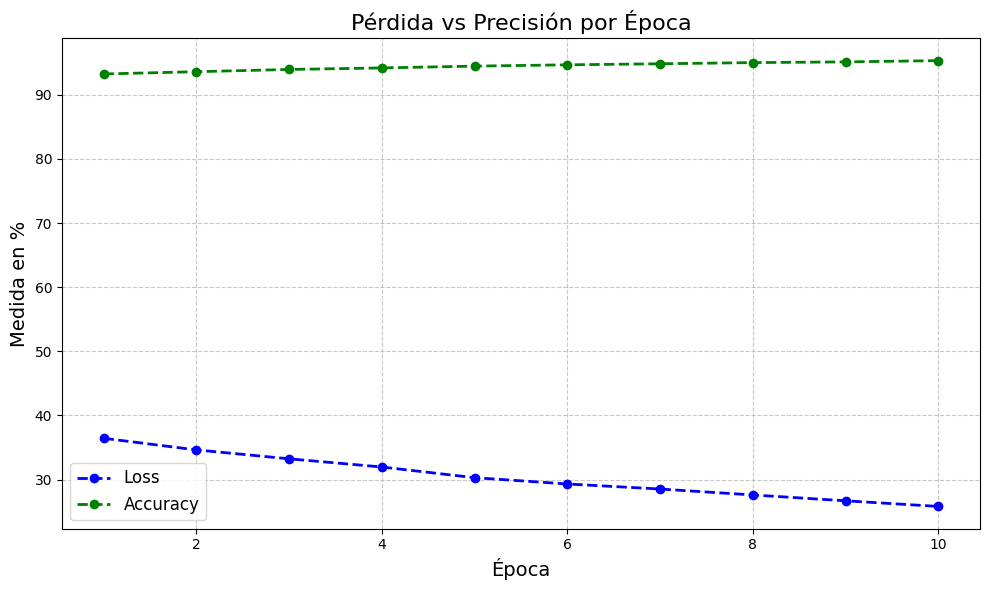

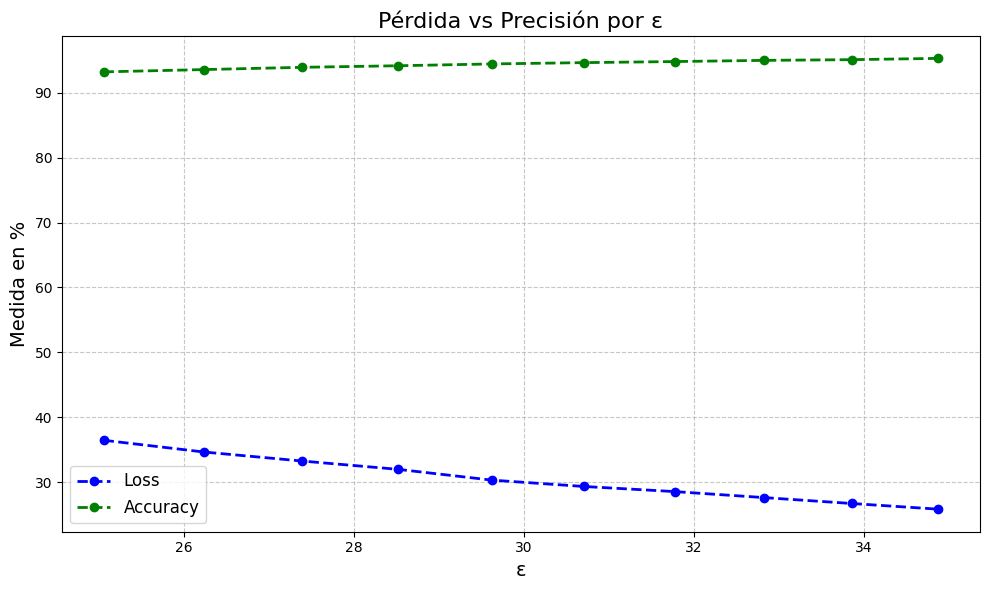

In [35]:
plot_metrics('Pérdida vs Precisión por Época', 'Época', 'Medida en %', MLossXepoc, 'Loss', ACCxEpoc, 'Accuracy', epochX, 'loss_vs_acc.png')
plot_metrics('Pérdida vs Precisión por ε', 'ε', 'Medida en %', MLossXepoc, 'Loss', ACCxEpoc, 'Accuracy', EpsXEpoc, 'loss_vs_accuracy_by_epsilon.png')

In [38]:
print("Perdida: ", MLossXepoc)
print ("PRecision: ",ACCxEpoc)
print ("Epocas: ",epochX)
print ("PerEpsilondida: ",EpsXEpoc)

Perdida:  [36.44665066894493, 34.63179587648669, 33.243102580184804, 31.96494172441153, 30.30285346716432, 29.32012825371521, 28.533553566683384, 27.612114313896548, 26.698216584909247, 25.82084400403593]
PRecision:  [93.23166666666667, 93.58666666666667, 93.935, 94.17666666666666, 94.455, 94.65833333333333, 94.82166666666667, 95.005, 95.115, 95.31333333333333]
Epocas:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
PerEpsilondida:  [25.051843664963936, 26.23393323465557, 27.38747520773597, 28.515565942129914, 29.620984458164624, 30.706017847402887, 31.772579608296443, 32.822392287505416, 33.85672062794377, 34.87680160099994]


## Conclusión del Ejercicio de Privacidad Diferencial

Los resultados del ejercicio de privacidad diferencial proporcionan información valiosa sobre el rendimiento y la privacidad del modelo. A continuación, se presentan las conclusiones clave basadas en los datos proporcionados:

### Pérdida (Loss)
- La pérdida disminuye a medida que avanzan las épocas. Esto indica que el modelo está mejorando su capacidad para hacer predicciones correctas en el conjunto de datos de entrenamiento.

### Precisión (Accuracy)
- La precisión aumenta a medida que avanzan las épocas. Esto es un signo positivo, ya que demuestra que el modelo está aprendiendo a clasificar correctamente más ejemplos.

### Epsilon (ε)
- Cuanto mayor sea el valor de epsilon, mayor será la privacidad diferencial proporcionada al modelo.A medida que el valor de epsilon (ε) aumenta, la cantidad de ruido agregada al gradiente disminuye, lo que puede conducir a un mejor rendimiento en términos de precisión en el conjunto de datos de entrenamiento. Esto se debe a que con un valor mayor de ε, el modelo se ajusta más estrechamente a los datos reales, ya que se introduce menos ruido en el proceso de entrenamiento. En otras palabras, el modelo puede aprender más de los datos reales y ajustarse mejor a ellos.

### Épocas
- El entrenamiento se realizó durante 10 épocas, lo que indica que el modelo se entrenó en múltiples pasadas a través del conjunto de datos de entrenamiento.

Los resultados sugieren que el modelo está mejorando su rendimiento en términos de pérdida y precisión a medida que se entrena durante más épocas. Además, el aumento en el valor de epsilon indica un menor nivel de privacidad diferencial.

Sin embargo, esta mejora en la precisión en el conjunto de datos de entrenamiento puede no ser necesariamente beneficiosa en todos los casos. La privacidad diferencial busca proteger la privacidad de los datos individuales y garantizar que los resultados del modelo no divulguen información sensible sobre ningún ejemplo de entrenamiento específico. Por lo tanto, existe un equilibrio entre la precisión y la privacidad en la elección de ε.

Es importante recordar que, si bien un mayor valor de ε puede mejorar la precisión en el conjunto de entrenamiento, también puede reducir la garantía de privacidad diferencial, lo que significa que el modelo podría estar filtrando más información sobre los datos individuales. Por lo tanto, la elección de ε debe basarse en un equilibrio entre la precisión y la privacidad que se adapte a las necesidades y requisitos específicos del problema.

La elección de epsilon debe basarse en un equilibrio entre la privacidad y el rendimiento que se ajuste a las necesidades del problema específico. Los resultados obtenidos son un indicador del éxito del entrenamiento del modelo bajo el contexto de la privacidad diferencial.


## Fuentes y Referencias

Este proyecto se basó en información recopilada de diversas fuentes y publicaciones. A continuación, se enumeran las fuentes utilizadas:

1. **What is the Privacy Accounting usage?**
   - Publicación: Agosto 2022
   - URL: [Discusión en PyTorch](https://discuss.pytorch.org/t/what-is-the-privacy-accounting-usage/159018/3)

2. **Guide: How to migrate to 1.0 API**
   - Consultado el 28-09-2023
   - URL: [GitHub - Opacus](https://github.com/pytorch/opacus/blob/main/Migration_Guide.md)

3. **Privacy Engine**
   - Consultado el 28-09-2023
   - URL: [Documentación de Opacus](https://opacus.ai/api/privacy_engine.html)

4. **Differential Privacy Series Part 1 | DP-SGD Algorithm Explained**
   - Publicado en PyTorch el 31 de agosto de 2020
   - Consultado el 28-09-2023
   - URL: [Medium - PyTorch](https://medium.com/pytorch/differential-privacy-series-part-1-dp-sgd-algorithm-explained-12512c3959a3)

5. **DIFFERENTIALLY PRIVATE DEEP LEARNING IN 20 LINES OF CODE: HOW TO USE THE PYTORCH OPACUS LIBRARY**
   - Publicado el 31 de agosto de 2020
   - URL: [Blog de OpenMined](https://blog.openmined.org/differentially-private-deep-learning-using-opacus-in-20-lines-of-code/)

6. **FAQ**
   - Consultado el 28-09-2023
   - URL: [Documentación de Opacus - FAQ](https://opacus.ai/docs/faq)

Estas fuentes proporcionaron información valiosa para la implementación de la privacidad diferencial en este proyecto.
